### <font color=darkred> [MSA : Modélisation, Apprentissage et Applications] </font>
### <font color = darkblue> <div style="text-align: center"> Projet de fin d'études
### <font color = darkblue> <div style="text-align: center"> Données objectives réelles
## <font color = darkgreen> <div style="text-align: center"> Apprentissage Statistique appliqué à la qualité de vie au travail
### <font color = darkgreen> <div style="text-align: center"> [Smart Building & OZE Energies]
#### <font color = darkblue> <div style="text-align: right"> Binôme : Jordan CHEMOUHOUM, Alaeddine ZEKRI

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
#Format des données
import pandas as pd
import numpy as np

#Outils de graphs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ACP
from sklearn.preprocessing import StandardScaler

#Label Encoder
from sklearn import preprocessing

#Machine Learning tools
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#Machine Learning Models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier

In [2]:
train_input = pd.read_csv('./Data/train_input.csv')
train_output = pd.read_csv('./Data/train_output.csv',header=None,names=['label'])
test_input = pd.read_csv('./Data/test_input.csv')
test_output = pd.read_csv('./Data/test_output.csv',header=None,names=['label'])

In [3]:
test_input.head()

,ID,Date,Temperature,Humidity,Humex,CO2,Bright
0,8000,2018-06-11 08:20:00,23.7,62.0,28.3,418.0,84.0
1,8001,2018-07-18 18:50:00,25.4,39.0,26.9,571.0,66.0
2,8002,2018-07-22 15:50:00,28.6,49.0,33.8,330.0,0.0
3,8003,2018-05-17 23:10:00,24.0,30.0,23.4,463.0,1.0
4,8004,2018-03-25 01:10:00,22.5,30.0,21.5,447.0,0.0


In [4]:
train_input = train_input.drop(['ID'],axis=1)
test_input = test_input.drop(['ID'],axis=1)

In [5]:
print('Taille échantillon apprentissage : ', train_input.shape[0])

Taille échantillon apprentissage :  8000


In [6]:
print('Taille échantillon test : ', test_input.shape[0])

Taille échantillon test :  2000


### Traitement des Nan

In [7]:
train_input.isnull().sum(axis = 0)

Date             0
Temperature      0
Humidity        12
Humex            0
CO2            585
Bright         217
dtype: int64

In [8]:
test_input.isnull().sum(axis = 0)

Date             0
Temperature      0
Humidity         5
Humex            0
CO2            137
Bright          52
dtype: int64

In [10]:
train_input.median()

Temperature     23.9
Humidity        40.0
Humex           24.8
CO2            595.0
Bright           2.0
dtype: float64

In [11]:
train_input.mean()

Temperature     23.642350
Humidity        40.245618
Humex           24.679000
CO2            649.772893
Bright          72.175254
dtype: float64

In [12]:
test_input.median()

Temperature     23.8
Humidity        40.0
Humex           24.8
CO2            589.0
Bright           2.0
dtype: float64

In [13]:
test_input.mean()

Temperature     23.574600
Humidity        40.260150
Humex           24.591400
CO2            648.045089
Bright          75.943532
dtype: float64

- Pour ne pas perdre des observation (on en a que 10000), nous remplaçons dans un premier temps les valeurs manquantes par la **moyenne** ou la **médiane**. 
- Moyenne et Médiane donne des résultats semblables pour la plupart des variables sauf pour **Bright**
- Voyons alors la distribution de la variable **Bright**

{'boxes': [<matplotlib.lines.Line2D at 0x111e416a0>],
 'caps': [<matplotlib.lines.Line2D at 0x111e4b0f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x111e4bd68>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x111e4b940>],
 'whiskers': [<matplotlib.lines.Line2D at 0x111e417f0>,
  <matplotlib.lines.Line2D at 0x111e41c88>]}

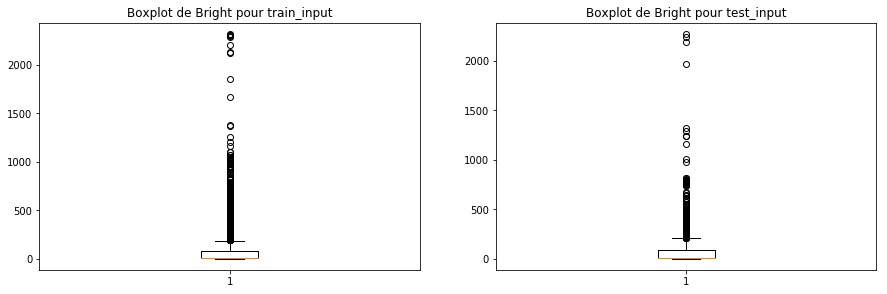

In [14]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.title('Boxplot de Bright pour train_input')
plt.boxplot(data=train_input.dropna(), x='Bright')

plt.subplot(222)
plt.title('Boxplot de Bright pour test_input')
plt.boxplot(data=test_input.dropna(), x='Bright')

In [15]:
train_input.Bright.describe()

count    7783.000000
mean       72.175254
std       167.627121
min         0.000000
25%         1.000000
50%         2.000000
75%        77.000000
max      2318.000000
Name: Bright, dtype: float64

- Ayant beaucoup d'**outliers** pour la variable **Bright**, nous la remplaçons par la **Médiane**.

In [9]:
train_input = train_input.fillna(train_input.median())
test_input = test_input.fillna(train_input.median())

### Traitement de Date
### 1/ Sans One_Hot_Encoding

- Nous extrayons 4 nouvelles variable à partir de Date : 
    - hour
    - month
    - quarter
    - week-end (1 si Samedi/dimanche, 0 sinon)

In [10]:
date = train_input['Date']
date = date.apply(pd.Timestamp)
dates = pd.DataFrame({"month": date.dt.month,
              "hour": date.dt.hour,
              "weekday": date.dt.weekday,
              "quarter": date.dt.quarter,
             })
train_input = pd.concat([train_input,dates],axis=1)
train_input['week-end'] = ((train_input.weekday==5) | (train_input.weekday==6)).astype(int)
train_input = train_input.drop(['weekday'],axis=1)

In [11]:
date = test_input['Date']
date = date.apply(pd.Timestamp)
dates = pd.DataFrame({"month": date.dt.month,
              "hour": date.dt.hour,
              "weekday": date.dt.weekday,
              "quarter": date.dt.quarter,
             })
test_input = pd.concat([test_input,dates],axis=1)
test_input['week-end'] = ((test_input.weekday==5) | (test_input.weekday==6)).astype(int)
test_input = test_input.drop(['weekday'],axis=1)

In [12]:
train_input.head()

,Date,Temperature,Humidity,Humex,CO2,Bright,hour,month,quarter,week-end
0,2018-06-17 04:20:00,25.0,40.0,26.5,519.0,1.0,4,6,2,1
1,2018-03-20 03:40:00,19.1,26.0,16.7,607.0,1.0,3,3,1,0
2,2018-07-22 17:20:00,29.3,48.0,34.7,326.0,0.0,17,7,3,1
3,2018-04-08 00:30:00,25.1,37.0,26.1,641.0,1.0,0,4,2,1
4,2018-04-21 03:20:00,25.1,36.0,25.9,572.0,1.0,3,4,2,1


###  Preprocessing / Exploration des variables

#### Distribution des données suivant les Labels

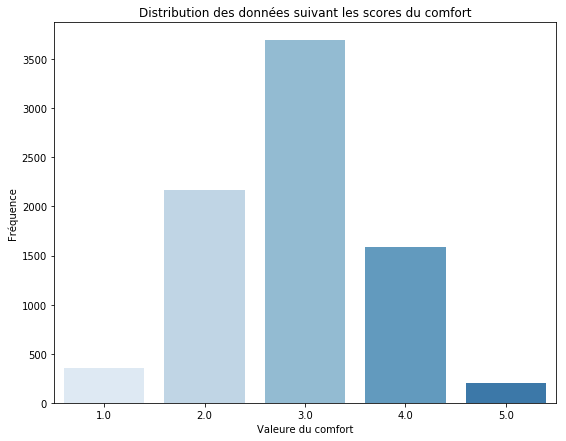

In [49]:
plt.figure(figsize=(9,7))
sns.countplot(x='label', data=train_output,palette=sns.color_palette("Blues"))
plt.ylabel('Fréquence')
plt.xlabel('Valeure du comfort')
plt.title("Distribution des données suivant les scores du comfort")
plt.show()

#### Correlation entre les variables

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


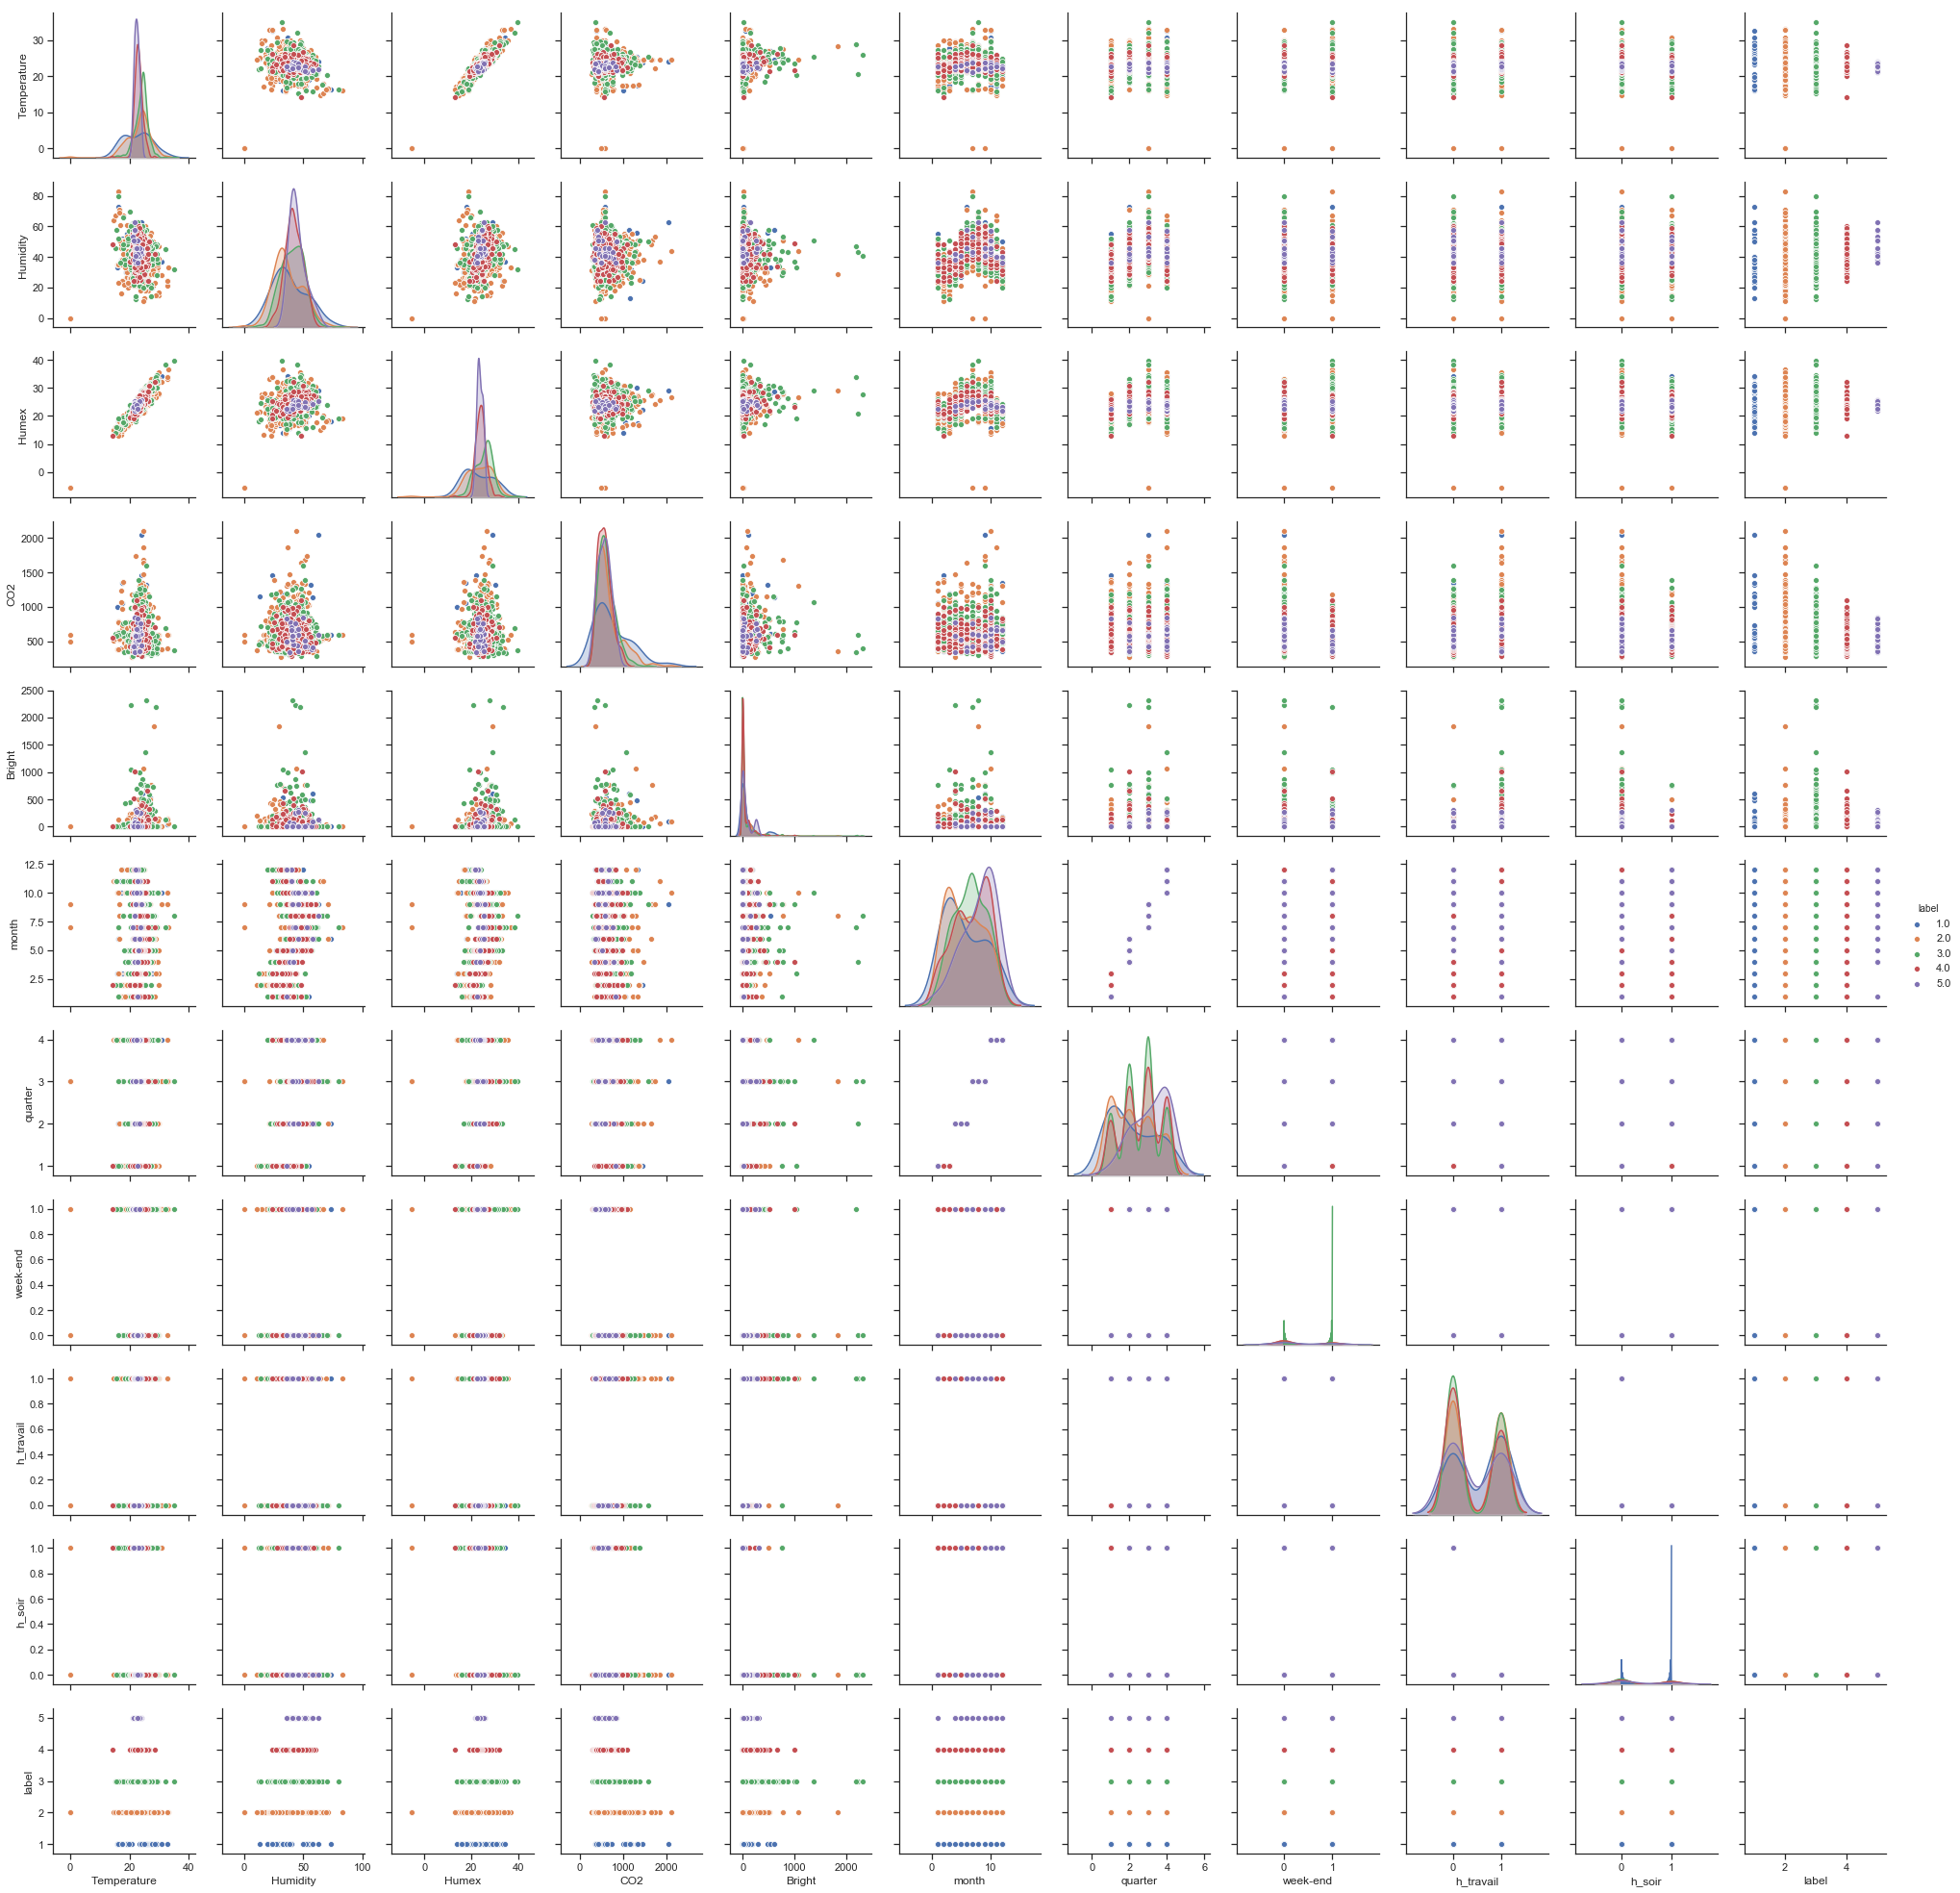

In [68]:
sns.set(style="ticks")
sns.pairplot(pd.concat([X_train.loc[:1000,],train_output.loc[:1000]],axis=1), hue="label")

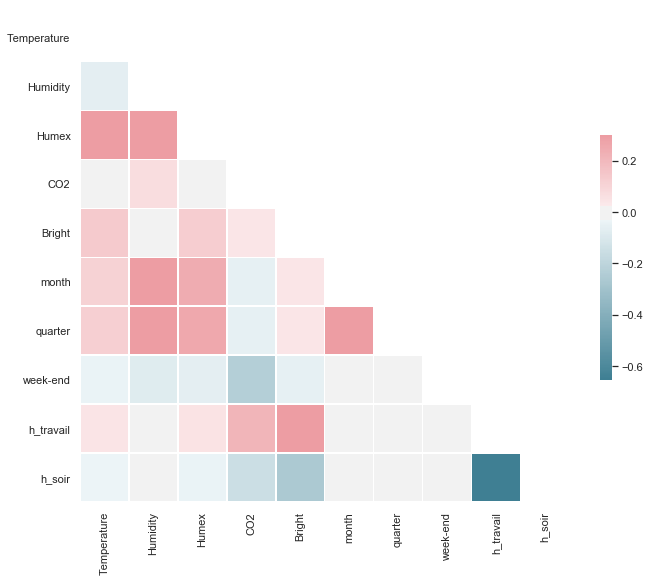

In [60]:
sns.set(style="white")

corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 2/ Avec One_Hot_Encoding

In [13]:
train_input_ohe = pd.get_dummies(train_input,columns=['hour','month','quarter'])
test_input_ohe = pd.get_dummies(test_input,columns=['hour','month','quarter'])

In [14]:
train_input_ohe.head()

,Date,Temperature,Humidity,Humex,CO2,Bright,week-end,hour_0,hour_1,hour_2,...,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,2018-06-17 04:20:00,25.0,40.0,26.5,519.0,1.0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2018-03-20 03:40:00,19.1,26.0,16.7,607.0,1.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2018-07-22 17:20:00,29.3,48.0,34.7,326.0,0.0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,2018-04-08 00:30:00,25.1,37.0,26.1,641.0,1.0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2018-04-21 03:20:00,25.1,36.0,25.9,572.0,1.0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### <font color=darkred> Comparaison des modèles de ML

In [78]:
X_train = train_input.drop(['Date'],axis=1)
X_test = test_input.drop(['Date'],axis=1)
y_train = train_output['label']
y_test = test_output['label']

X_train_ohe = train_input_ohe.drop(['Date'],axis=1)
X_test_ohe = test_input_ohe.drop(['Date'],axis=1)

In [17]:
import xgboost as xgb

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
models = []
models.append(('Logistic Regression',LogisticRegression()))
models.append(('SVC',SVC(probability=True)))
models.append(('SVM_k_poly',SVC(kernel='poly', degree=2, coef0=0, probability=True)))
models.append(('KNN',KNeighborsClassifier()))
models.append(('Decision Tree Classifier',DecisionTreeClassifier()))
models.append(('DTC with Bagging',BaggingClassifier(DecisionTreeClassifier() , max_samples=0.4, n_estimators=100)))
models.append(('Gradient Boosting Classifier',GradientBoostingClassifier()))
models.append(('AdaBoost Classifier',AdaBoostClassifier()))
models.append(('Random Forest Classifier',RandomForestClassifier()))
models.append(('Xgboost',xgb.XGBClassifier()))

### Normalisation des données

In [89]:
from sklearn.preprocessing import scale
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)
X_train_ohe_scaled = scale(X_train_ohe)
X_test_ohe_scaled = scale(X_test_ohe)

In [27]:
accuracy_results = list()
accuracy_results_ohe = list()

index = [m[0] for m in models]
for nom_model,model in models:
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=7, scoring='accuracy')
    accuracy_results.append(cv_results.mean()*100)
    cv_results_ohe = cross_val_score(model, X_train_ohe_scaled, y_train, cv=7, scoring='accuracy')
    accuracy_results_ohe.append(cv_results_ohe.mean()*100)

Performance_results_scaled = pd.DataFrame(accuracy_results , index=index , columns= ['Performance sans ohe en %'])
Performance_results_scaled['Performance avec ohe en %'] = accuracy_results_ohe 

In [28]:
Performance_results_scaled

,Performance sans ohe en %,Performance avec ohe en %
Logistic Regression,47.387078,47.387637
SVC,62.050472,52.312215
SVM_k_poly,51.888197,51.175632
KNN,58.300442,46.462948
Decision Tree Classifier,54.413805,56.614189
DTC with Bagging,71.364196,71.514047
Gradient Boosting Classifier,71.013999,71.126277
AdaBoost Classifier,57.563491,57.563491
Random Forest Classifier,66.338253,63.000979
Xgboost,71.013616,70.963633


In [29]:
best_classifier = BaggingClassifier(DecisionTreeClassifier() , max_samples=0.4, n_estimators=100)
best_classifier.fit(X_train_ohe_scaled, y_train)
y_predicted = best_classifier.predict(X_test_ohe_scaled)
print('Performances de DTC with Bagging avec ohe : ', np.mean(y_predicted==y_test)*100,' %')

Performances de DTC with Bagging avec ohe :  70.1  %


In [127]:
best_classifier = BaggingClassifier(DecisionTreeClassifier() , max_samples=0.4, n_estimators=100)
best_classifier.fit(X_train_scaled, y_train)
y_predicted = best_classifier.predict(X_test_scaled)
print('Performances de DTC with Bagging sans ohe : ', np.mean(y_predicted==y_test)*100,' %')

Performances de DTC with Bagging sans ohe :  69.65  %


In [30]:
best_classifier = xgb.XGBClassifier()
best_classifier.fit(X_train_scaled, y_train)
y_predicted = best_classifier.predict(X_test_scaled)
print('Performances de Xgboost sans ohe : ', np.mean(y_predicted==y_test)*100,' %')

Performances de Xgboost sans ohe :  69.19999999999999  %


- Nous constatons que : 
    - Le meilleur classifieur est le Decision Tree avec Bagging sur les données qui ont subit du OHE

### 3/ Création de nouvelles features : h_travail, h_soir et h_maintain

In [79]:
X_train_n = X_train.copy()
X_test_n = X_test.copy()

X_train_n['h_travail'] = [0 for i in range(len(X_train_n['hour']))]
X_train_n['h_soir'] = [0 for i in range(len(X_train_n['hour']))]
X_train_n['h_maintain'] = [0 for i in range(len(X_train_n['hour']))]

X_test_n['h_travail'] = [0 for i in range(len(X_test_n['hour']))]
X_test_n['h_soir'] = [0 for i in range(len(X_test_n['hour']))]
X_test_n['h_maintain'] = [0 for i in range(len(X_test_n['hour']))]



s = X_train_n.hour.apply(lambda x : x in range(8,19))
s = s.apply(lambda x : int(x))
X_train_n.h_travail = s

s = X_train_n.hour.apply(lambda x : x in [21,22,23,0,1,2,3,4])
s = s.apply(lambda x : int(x))
X_train_n.h_soir = s

s = X_train_n.hour.apply(lambda x : x in [5,6,7,19,20])
s = s.apply(lambda x : int(x))
X_train_n.h_maintain = s


s = X_test_n.hour.apply(lambda x : x in range(8,19))
s = s.apply(lambda x : int(x))
X_test_n.h_travail = s

s = X_test_n.hour.apply(lambda x : x in [21,22,23,0,1,2,3,4])
s = s.apply(lambda x : int(x))
X_test_n.h_soir = s

s = X_test_n.hour.apply(lambda x : x in [5,6,7,19,20])
s = s.apply(lambda x : int(x))
X_test_n.h_maintain = s

# En accord avec les résultats au dessus, nous faisons du OHE sur month et quarter
X_train_n = pd.get_dummies(X_train_n,columns=['month','quarter'])
X_test_n = pd.get_dummies(X_test_n,columns=['month','quarter'])

X_train_n = X_train_n.drop(['hour'], axis=1)
X_test_n = X_test_n.drop(['hour'], axis=1)

X_train_n.drop(['h_maintain'],axis=1, inplace=True)
X_test_n.drop(['h_maintain'],axis=1, inplace=True)

- Dans les 3 nouvelles variables crées h_travail, h_soir et h_maintain, l'une des 3 est redondante, puisqu'il suffit d'en avoir 2 pour deviner la 3ème.
- Nous enlevons alors l'une des 3 variables (h_maintain par exemple)

In [82]:
X_train_scaled_n = scale(X_train_n)
X_test_scaled_n = scale(X_test_n)

In [83]:
best_classifier = BaggingClassifier(DecisionTreeClassifier() , max_samples=0.4, n_estimators=100)
best_classifier.fit(X_train_scaled_n, y_train)
y_predicted = best_classifier.predict(X_test_scaled_n)
print('Performances de DTC with Bagging avec les new_features + ohe : ', np.mean(y_predicted==y_test)*100,' %')

Performances de DTC with Bagging avec les new_features + ohe :  69.69999999999999  %


- Nous perdons de la précision en créant de nouvelles variables à partir de hour et en appliquant du OHE sur month et quarter

### Amélioration du meilleur modèle avec GridSearch
- Nous décidons de garder les 2 classifieurs suivants :
    - DTC avec Bagging (sans OHE)
    - Xgboost (sans OHE)
- Nous les améliorons en choisissant les meilleurs paramètres avec un GridSearch

#### GridSearch sur DTC

In [101]:
best_clf = DecisionTreeClassifier()
best_clf.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')>

In [110]:
param_grid = {'max_depth' : np.arange(3,10),
              'min_samples_split' : [2,3,4],
              'max_leaf_nodes' : np.arange(10,20)   
             }
clf = GridSearchCV(best_clf,param_grid, cv=5)

In [111]:
clf.fit(X_train_scaled,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9]), 'min_samples_split': [2, 3, 4], 'max_leaf_nodes': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [112]:
clf.best_params_

{'max_depth': 7, 'max_leaf_nodes': 19, 'min_samples_split': 2}

In [113]:
clf.best_score_

0.668625

#### GridSearch sur Bagging

In [114]:
best_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=7,max_leaf_nodes=19,min_samples_split=2))
best_clf.get_params

<bound method BaseEstimator.get_params of BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=19,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)>

In [115]:
param_grid = {
              'n_estimators' : [10,50,100,200],
              'max_samples' : [0.2,0.4,0.8,1]
             }
clf = GridSearchCV(best_clf,param_grid, cv=5)

In [116]:
clf.fit(X_train_scaled,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=19,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_w...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 200], 'max_samples': [0.2, 0.4, 0.8, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [117]:
clf.best_params_

{'max_samples': 0.4, 'n_estimators': 100}

In [118]:
clf.best_score_

0.68375

#### Evaluation du classifieur après GridSearch

In [126]:
best_classifier = BaggingClassifier(DecisionTreeClassifier(max_depth=7,max_leaf_nodes=19,min_samples_split=2), max_samples=0.4, n_estimators=100)
best_classifier.fit(X_train_scaled, y_train)
y_predicted = best_classifier.predict(X_test_scaled)
print('Performances de DTC with Bagging sans ohe : ', np.mean(y_predicted==y_test)*100,' %')

Performances de DTC with Bagging sans ohe :  66.4  %
